In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shapely
from PIL import Image
import argparse
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import polygon_primitives.file_writer as fw

from image_processing import extract_window_wall_ratio, utils, contour_extraction
from scipy.spatial import Delaunay

In [2]:
%pwd

'/Users/akprakash/Programming/autobfe/a3dbr/Example_Notebooks'

First, we set the image and parameter directories, as well as the merged polygons file path. We load the merged polygons, as we also initialize a dictionary for the Cameras. The Camera class stores all information related to the camera, i.e. intrinsic and extrinsic camera parameters.

In [3]:
#Example file
filename = "DJI_0488.JPG"

directory = "/Users/akprakash/Programming/autobfe/olympic/"
facade_file = directory+ "olympic_merged_polygons.txt"

image_dir = directory + "olympic_rgb/images/"
param_dir = directory + "params/"
predictions_dir = directory + "olympic_rgb/probs/"
predictions_dir2 = directory + "olympic_rgb/probs2/"

offset = np.loadtxt(directory + "olympic_polygon_offset.txt",usecols=range(3), delimiter=',')

#Initializes a dictionary of Camera classes. See utils.py for more information.
camera_dict = utils.create_camera_dict(param_dir, filename='merged_olympic_calibrated_camera_parameters.txt', offset=offset)

#Loads pmatrices and image filenamees
p_matrices = np.loadtxt(param_dir + 'merged_olympic_pmatrix.txt', usecols=range(1,13))

#Loads the merged polygons, as well as a list of facade types (i.e. roof, wall, or floor)
merged_polygons, facade_type_list, file_format = fw.load_merged_polygon_facades(filename=facade_file)

#Offset adjustment parameter
height_adj = np.array([0.0, 0.0, 108])
offset = offset + height_adj


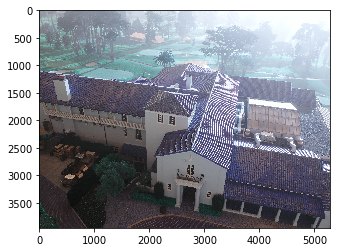

In [4]:
image_file = image_dir + filename

image = cv2.imread(image_file)
plt.imshow(image)
plt.show()

Window predictions: 


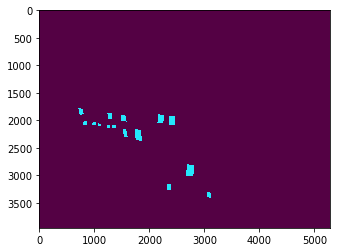

(3956, 5280, 3)


In [5]:
window_file = predictions_dir + filename.split(".")[0] +".png"

print("Window predictions: ")
pred_image = cv2.imread(window_file)
plt.imshow(pred_image)
plt.show()
print(pred_image.shape)

In [20]:
new_pred_image = []
for x in pred_image:
    new_y = []
    for y in x:
        if not np.array_equal(y, np.array([84, 1, 68])):
            new_y.append(np.array([89, 0, 237]))
        else: 
            new_y.append(np.array([236, 237, 237]))
    new_pred_image.append(np.array(new_y))

Next, we extract the contours for the window predictions, by taking the window prediction points and using them to create a shapely polygon.

In [7]:
pred_image2 = np.array(new_pred_image, dtype='uint8')

from PIL import Image
im = Image.fromarray(pred_image2)
plt.imshow(im)
im.save(predictions_dir2+filename.split(".")[0] +".png")

NameError: name 'new_pred_image' is not defined

Window predictions: 


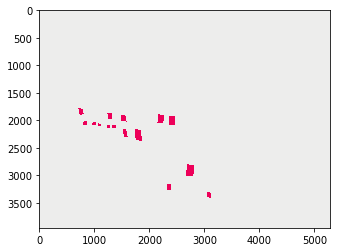

Extracted contours: 


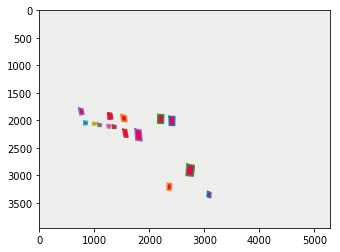

In [6]:
window_file = predictions_dir2 + filename.split(".")[0] +".png"

print("Window predictions: ")
image = cv2.imread(window_file)
plt.imshow(image)
plt.show()

#Extract the contours of the window file
contours = contour_extraction.extract_contours(window_file)

#Create polygons from the window contours
window_polygons = utils.convert_polygons_shapely(contours)


def plot_shapely_polys(image_file, polys):
    for poly in polys:
        s = poly
        s = poly.simplify(0.1, preserve_topology=True)
        x,y = s.exterior.xy
        plt.plot(x,y)
    plt.show()

print("Extracted contours: ")
plt.imshow(image)
plot_shapely_polys(window_file, window_polygons)

Finally, for each window point, we obtain its 3D coordinates and use them to calculate the window to wall ratio.

In [7]:
camera = camera_dict[filename]
pmatrix = camera.calc_pmatrix()

image_file = utils.load_image(image_dir + filename)

#Projects the merged polygon facades onto the camera image
projected_facades, projective_distances = extract_window_wall_ratio.project_merged_polygons(
    merged_polygons, offset, pmatrix)

#Creates a dictionary mapping the facade to the windows contained within them, keyed by facade index
facade_window_map = extract_window_wall_ratio.get_facade_window_map(
    window_polygons, projected_facades, projective_distances)

#Creates a list of all the facades in the merged polygon
facades = []
for poly in merged_polygons:
    facades = facades + poly

facade_indices = list(facade_window_map.keys())
for i in facade_indices:
    #Computes window to wall ratio
    win_wall_ratio = extract_window_wall_ratio.get_window_wall_ratio(
        projected_facades[i], facades[i], facade_window_map[i])

    #Output printing:
    print("Facade index: " + str(i))
    print("Window-to-wall ratio: " + str(win_wall_ratio))
    
    #Uncomment this line to plot the windows and facades on the image
#     extract_window_wall_ratio.plot_windows_facade(projected_facades[i], facade_window_map[i], image_file)

facade_area: 441.4192408057005
None
window_area: 65.14806653468729
None
Facade index: 58
Window-to-wall ratio: 0.14758773635643016
facade_area: 193.8952543194223
None
window_area: nan
None
Facade index: 77
Window-to-wall ratio: 0


/Users/akprakash/Programming/autobfe/a3dbr/image_processing/extract_window_wall_ratio.py:106: RuntimeWarning: invalid value encountered in true_divide
  return v / np.linalg.norm(v)


In [24]:
window_total_area = 0
for window in window_polygons:
    window_total_area+=window.area
facade_total_area = 0
for facade in projected_facades:
    facade_total_area+=facade.area
print(window_total_area)
print(facade_total_area)
print("total wwr = {}".format(window_total_area/facade_total_area))

149171.0
2541626.0
total wwr = 0.05869116856689379


In [9]:
facade_window_map

{58: [<shapely.geometry.polygon.Polygon at 0x7fc4c05c35c0>],
 77: [<shapely.geometry.polygon.Polygon at 0x7fc4c05c3898>]}

In [21]:
i = 0
for window2 in projected_facades:
    res = shapely.geometry.mapping(window2)
    coords_tuples = res.get('coordinates')[0]
    coords = []
    for coord_tuple in coords_tuples:
        
        coords.append(np.array(list(coord_tuple)).astype('int32'))
    print(window2.area)
    
    image_file = image_dir + filename
    image = cv2.imread(image_file)
    
#     cv2.rectangle(image,(0,0),(2000,2000),(255,0,0),-1)
    cv2.polylines(image, coords, 1, (255, 0, 0), -1)

    cv2.imwrite("olympic_facade/olympic_facade{}.png".format(i),image)
#     image = cv2.imread("my.png")
    # cv2.imshow("lalala", img)
    # k = cv2.waitKey(0) # 0==wait forever
    i+=1

50686.5


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-olkhgde0/opencv/modules/imgproc/src/drawing.cpp:2427: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'polylines'


In [17]:
image_file = image_dir + filename

image = cv2.imread(image_file)

cv2.rectangle(image,(0,0),(2000,2000),(255,0,0),-1)

cv2.imwrite("my.png",image)
image = cv2.imread("my.png")
# cv2.imshow("lalala", img)
# k = cv2.waitKey(0) # 0==wait forever

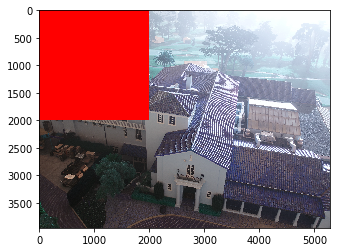

In [18]:
image = cv2.imread('my.png')
plt.imshow(image)